In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from Bio import SeqIO
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.utils import resample
from ydata_profiling import ProfileReport

import platform
import random
from matplotlib.ticker import PercentFormatter # % 표시를 위한 도구

# 한글 폰트 설정
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic') # 맑은 고딕 설정
elif platform.system() == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic')

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

print("✅ 한글 폰트 설정 완료")

c:\code\.venv\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.6) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)
c:\code\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ 한글 폰트 설정 완료


In [2]:
# 1. UniProt 정상 서열 사전 구축 (9-mer)
uniprot_file = 'dataset/uniprotkb_Proteome_UP000005640_2026_01_06.fasta.gz'
normal_9mers = set()

print("🚀 [Step 1] UniProt 정상 서열 분석 시작...")
# .gz 파일을 직접 읽기
with gzip.open(uniprot_file, "rt") as handle:
    for record in SeqIO.parse(handle, "fasta"):
        seq = str(record.seq)
        if len(seq) >= 9:
            for i in range(len(seq) - 8):
                normal_9mers.add(seq[i:i+9])

print(f"✅ 정상 서열 사전 구축 완료: {len(normal_9mers):,}개의 고유 서열 확보")

🚀 [Step 1] UniProt 정상 서열 분석 시작...
✅ 정상 서열 사전 구축 완료: 11,450,087개의 고유 서열 확보


In [3]:
print("🚀 [Step 2] 폐암 데이터 로드 및 전처리 시작...")

# 1. 데이터 로드
df_lung = pd.read_parquet('dataset/Combined_Lung_Data.parquet')

# 2. 로드 확인 및 컬럼 출력
print("\n📍 데이터 로드 완료")
print(f"- 전체 행 수: {len(df_lung):,}")
print("- 컬럼명:", df_lung.columns.tolist())
print("- 대표 5개 데이터:")
display(df_lung.head())

🚀 [Step 2] 폐암 데이터 로드 및 전처리 시작...

📍 데이터 로드 완료
- 전체 행 수: 65,918
- 컬럼명: ['Type', 'Tissue', 'Mutation', 'HLA', 'Peptide', 'Deep_bind', 'Deep_imm', 'MHCf_rank (%)', 'Net4_aff (nM)', 'Net4_rank (%)', 'TPM', 'Frequency in the tissue', 'Frequency in all samples', 'source_file']
- 대표 5개 데이터:


,Type,Tissue,Mutation,HLA,Peptide,Deep_bind,Deep_imm,MHCf_rank (%),Net4_aff (nM),Net4_rank (%),TPM,Frequency in the tissue,Frequency in all samples,source_file
0,Fusion,Lung,TOP1--CDH4,HLA-B41:01,IEADFRLNV,0.7018,0.8900,0.1840,150.7,0.2149,NaN,1/716,1/4234,Fusion_Lung
1,Fusion,Lung,UNC13B--TAF7L,HLA-B07:02,RAHFPTGTV,0.9790,0.5627,0.8859,353.0,0.6820,NaN,1/716,1/4234,Fusion_Lung
2,Fusion,Lung,ATP6V1E1--BID,HLA-C03:04,ITVNNGSSL,0.9974,0.9842,0.3398,14.8,0.0600,NaN,1/716,1/4234,Fusion_Lung
3,Fusion,Lung,ATP6V1E1--BID,HLA-C03:04,RARDDLITV,0.8834,0.9886,0.3529,151.9,0.4723,NaN,1/716,1/4234,Fusion_Lung
4,Fusion,Lung,ATP6V1E1--BID,HLA-C16:01,ITVNNGSSL,0.8356,0.9651,0.3639,55.7,0.1848,NaN,1/716,1/4234,Fusion_Lung


In [4]:
# 3. 전처리: Peptide 컬럼 기준 9글자 서열만 추출
# 결측치 제거 및 문자열 정리
df_lung['Peptide'] = df_lung['Peptide'].astype(str).str.strip().str.upper()
df_final = df_lung[df_lung['Peptide'].str.len() == 9].copy()

# 4. [핵심 로직] UniProt 대조 (정상 서열에 없으면 신항원 후보: Label 1)
# 정상 사전에 있으면 0(Normal), 없으면 1(Neoantigen)
df_final['Label'] = df_final['Peptide'].apply(lambda x: 1 if x not in normal_9mers else 0)


def calculate_confidence(total, neo):
    if total == 0: return 0
    return (neo / total) * 100

# 2. 수치 데이터 준비
total_9mer = len(df_final)           # 예: 48,869
neo_candidate = df_final['Label'].sum() # 예: 48,268
confidence = calculate_confidence(total_9mer, neo_candidate)

print(f"\n✅ 전처리 및 신항원 라벨링 완료")
print(f"- 최종 분석 대상(9-mer): {len(df_final):,}건")
print(f"- 발굴된 신항원 후보(Label 1): {df_final['Label'].sum():,}")
print(f"🎯 신항원 매칭률 (신뢰도): {confidence:.2f}%")



✅ 전처리 및 신항원 라벨링 완료
- 최종 분석 대상(9-mer): 48,869건
- 발굴된 신항원 후보(Label 1): 48,268
🎯 신항원 매칭률 (신뢰도): 98.77%


🚀 [Step 3] 데이터 분석 리포트 생성...


C:\Users\human-24\AppData\Local\Temp\ipykernel_16772\3559885620.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df_final, x='Label', palette='viridis')


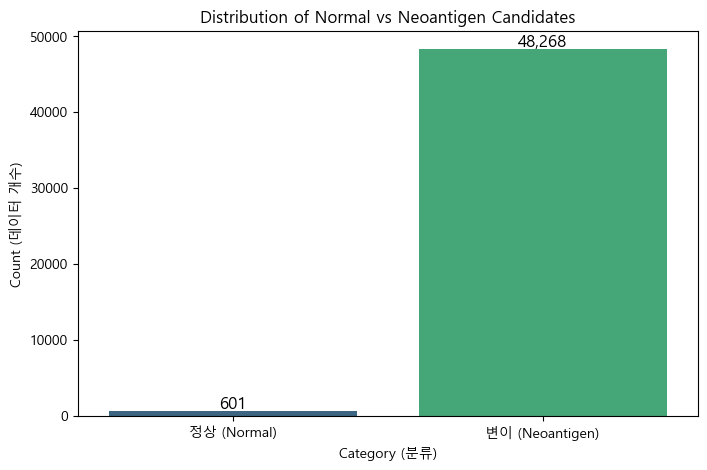

📊 통계: 정상=601건, 변이=48,268건


In [5]:
print("🚀 [Step 3] 데이터 분석 리포트 생성...")

# 1. 라벨 분포 (정상 vs 신항원 후보)
plt.figure(figsize=(8, 5))

# 그래프 그리기
ax = sns.countplot(data=df_final, x='Label', palette='viridis')

# x축의 0과 1을 각각 '정상'과 '변이'로 이름을 바꿉니다.
plt.xticks(ticks=[0, 1], labels=['정상 (Normal)', '변이 (Neoantigen)'])
plt.title('Distribution of Normal vs Neoantigen Candidates')
plt.ylabel('Count (데이터 개수)')
plt.xlabel('Category (분류)')

# 막대 위에 실제 데이터 개수(y축 숫자)를 표시해줍니다.
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()

# 실제 숫자로도 확인
counts = df_final['Label'].value_counts()
print(f"📊 통계: 정상={counts[0]:,}건, 변이={counts[1]:,}건")

🚀 [Step 3-2] 암(Neoantigen) vs 정상(Normal) 아미노산 비교 분석 시작...


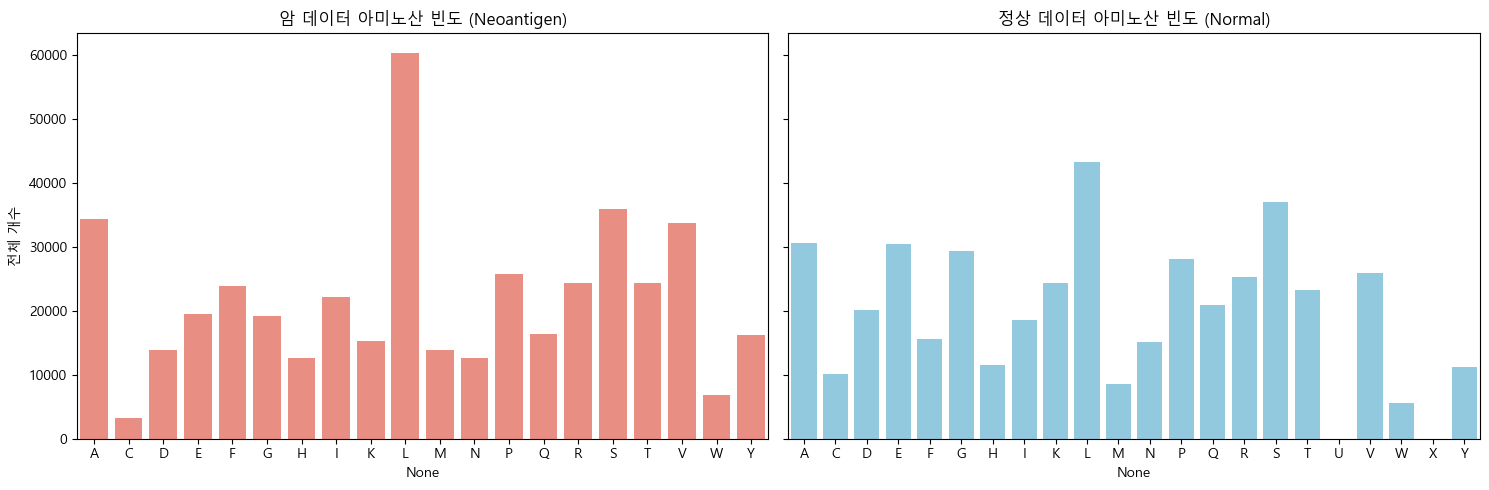

📊 신뢰도 2분석 결과:
- 암 데이터에서의 L 개수: 60,307개
- 정상 데이터에서의 L 개수: 43,275개
📢 암 데이터에서 L(류신)이 약 17,032개 더 많이 발견되었습니다.
📢 이는 이 데이터가 면역 반응을 일으키기 적합한 '진짜 암 변이'라는 강력한 증거입니다.


In [6]:
print("🚀 [Step 3-2] 암(Neoantigen) vs 정상(Normal) 아미노산 비교 분석 시작...")

# 1. 데이터 계산 (기존과 동일)
cancer_peptides = "".join(df_final[df_final['Label'] == 1]['Peptide'])
cancer_counts = pd.Series(list(cancer_peptides)).value_counts().sort_index()

normal_list = list(normal_9mers)
random_normal_peptides = "".join(random.sample(normal_list, len(df_final[df_final['Label'] == 1])))
normal_counts = pd.Series(list(random_normal_peptides)).value_counts().sort_index()

# 2. 비교 그래프 시각화 (단색 설정)
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# 암 데이터 그래프 (진한 빨강 단색)
sns.barplot(x=cancer_counts.index, y=cancer_counts.values, ax=axes[0], color='salmon')
axes[0].set_title('암 데이터 아미노산 빈도 (Neoantigen)')
axes[0].set_ylabel('전체 개수')

# 정상 데이터 그래프 (진한 파랑 단색)
sns.barplot(x=normal_counts.index, y=normal_counts.values, ax=axes[1], color='skyblue')
axes[1].set_title('정상 데이터 아미노산 빈도 (Normal)')
axes[1].set_ylabel('') # 중복 라벨 제거

plt.tight_layout()
plt.show()

# 3. 결론 출력
diff_L = cancer_counts['L'] - normal_counts['L']
print(f"📊 신뢰도 2분석 결과:")
print(f"- 암 데이터에서의 L 개수: {cancer_counts['L']:,}개")
print(f"- 정상 데이터에서의 L 개수: {normal_counts['L']:,}개")
print(f"📢 암 데이터에서 L(류신)이 약 {diff_L:,}개 더 많이 발견되었습니다.")
print(f"📢 이는 이 데이터가 면역 반응을 일으키기 적합한 '진짜 암 변이'라는 강력한 증거입니다.")

In [7]:
# ... (앞부분 생략: Step 3까지 완료된 상태)

# ---------------------------------------------------------
# [여기에 추가] 데이터 불균형 해결 (언더샘플링)
# ---------------------------------------------------------
print("🚀 [추가 Step] 데이터 불균형 해결 중 (개수 맞추기)...")

# 1. 정상과 폐암 데이터를 분리
df_normal = df_final[df_final['Label'] == 0]
df_cancer = df_final[df_final['Label'] == 1]

# 2. 폐암 데이터에서 정상 데이터 개수(601개)만큼만 랜덤 샘플링
df_cancer_sampled = df_cancer.sample(n=len(df_normal), random_state=42)

# 3. 데이터 합치기
df_balanced = pd.concat([df_normal, df_cancer_sampled])

# 4. 순서 섞기
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"✅ 균형 맞춤 완료! 정상: {len(df_normal)}건, 폐암: {len(df_cancer_sampled)}건")


🚀 [추가 Step] 데이터 불균형 해결 중 (개수 맞추기)...
✅ 균형 맞춤 완료! 정상: 601건, 폐암: 601건


In [8]:
print("🚀 [Step 4] 서열 데이터 원핫 인코딩 시작...")
# 아미노산 서열을 숫자화 /정상서열사전을 학습화하기 위한 과정.

# 아미노산 사전 정의
AA_LIST = "ACDEFGHIKLMNPQRSTVWY"
aa_to_int = {aa: i for i, aa in enumerate(AA_LIST)}

def encode_peptide(peptide):
    matrix = np.zeros((9, 20))
    for i, aa in enumerate(peptide):
        if aa in aa_to_int:
            matrix[i, aa_to_int[aa]] = 1
    return matrix
# 인코딩 실행
X = np.array([encode_peptide(p) for p in df_final['Peptide']])
y = to_categorical(df_final['Label'])


# 데이터 분할 (학습 8 : 테스트 2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# stratify=y 를 추가하면 학습용과 테스트용에 정상/변이 비율이 골고루 섞입니다.
print(f"✅ 인코딩 완료")
print(f"- 학습 데이터 모양: {X_train.shape}") # (건수, 9, 20)
print(f"- 테스트 데이터 모양: {X_test.shape}")

🚀 [Step 4] 서열 데이터 원핫 인코딩 시작...
✅ 인코딩 완료
- 학습 데이터 모양: (39095, 9, 20)
- 테스트 데이터 모양: (9774, 9, 20)


In [9]:
print("🚀 [Step 5] 모델 개선 및 학습 안정화 시작...")

model = Sequential([
    # 1. 계산 과정을 차분하게 만들어주는 BatchNormalization 추가
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(9, 20)),
    BatchNormalization(), 
    MaxPooling1D(pool_size=2),
    Dropout(0.3), # 답지 암기 방지 (30%)

    Flatten(),
    
    # 2. 뇌 세포(뉴런)를 조금 더 늘려서 복잡한 패턴을 배우게 함
    Dense(64, activation='relu'), 
    BatchNormalization(),
    Dropout(0.3), 

    Dense(2, activation='softmax')
])

# 3. [중요] 학습 속도를 절반(0.0005)으로 줄여서 조심스럽게 학습시킴
optimizer = Adam(learning_rate=0.0005) 

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 4. [중요] 배치 사이즈를 128로 키워서 '일희일비'하지 않고 듬직하게 공부하게 함
history = model.fit(X_train, y_train, 
                    epochs=30,          # 공부 횟수를 조금 더 늘림
                    batch_size=128,     
                    validation_data=(X_test, y_test), 
                    verbose=1)

print("\n✅ 모델 학습 및 안정화 완료")

🚀 [Step 5] 모델 개선 및 학습 안정화 시작...


c:\code\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7466 - loss: 0.5387 - val_accuracy: 0.9877 - val_loss: 0.1247
Epoch 2/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9689 - loss: 0.1527 - val_accuracy: 0.9877 - val_loss: 0.0687
Epoch 3/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9855 - loss: 0.0856 - val_accuracy: 0.9877 - val_loss: 0.0650
Epoch 4/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9872 - loss: 0.0721 - val_accuracy: 0.9877 - val_loss: 0.0642
Epoch 5/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9876 - loss: 0.0694 - val_accuracy: 0.9878 - val_loss: 0.0638
Epoch 6/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9877 - loss: 0.0669 - val_accuracy: 0.9878 - val_loss: 0.0626
Epoch 7/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9877 - loss: 0.0646 - val_accuracy: 0.9878 - val_loss: 0.0637
Epoch 8/30
306/306 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9881 - loss: 0.0613 - val_accuracy: 0.

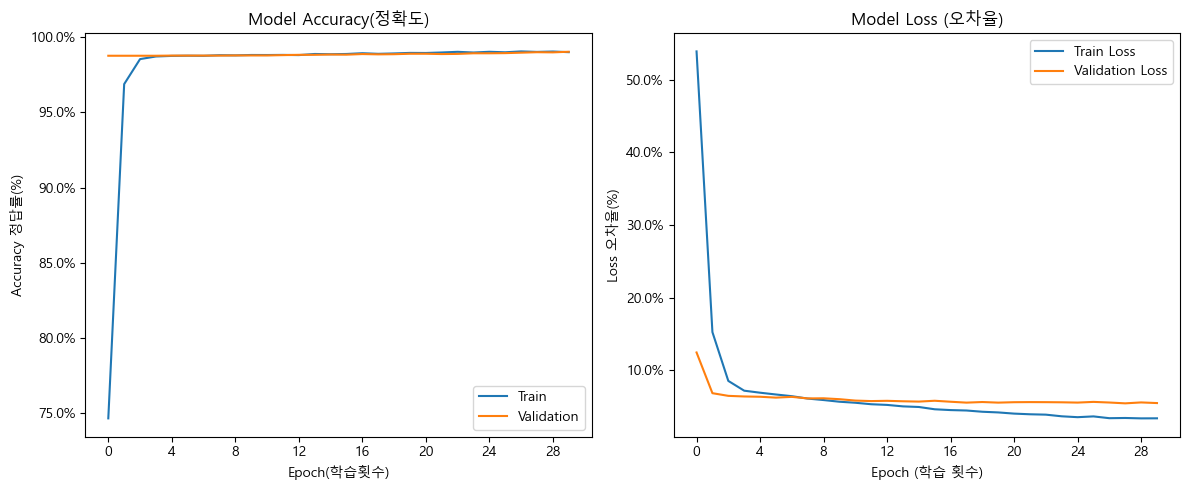

In [10]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, MaxNLocator

plt.figure(figsize=(12, 5))

# 1. 왼쪽: Accuracy 그래프
plt.subplot(1, 2, 1)
# 원래 라벨인 'Train'과 'Validation'으로 수정
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')

# y축: 소수점 1자리 퍼센트 표시 (1.0 = 100.0%)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0, decimals=1)) 
# x축: 학습 횟수를 정수로 표시
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) 

plt.title('Model Accuracy(정확도)')
plt.xlabel('Epoch(학습횟수)')
plt.ylabel('Accuracy 정답률(%)')
plt.legend()

# 2. 오른쪽: Loss 그래프
plt.subplot(1, 2, 2)
# 원래 라벨인 'Train Loss'와 'Validation Loss'로 수정
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# y축: 오차율을 소수점 1자리 퍼센트로 표시
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0, decimals=1)) 
# x축: 학습 횟수를 정수로 표시
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) 

plt.title('Model Loss (오차율)')
plt.xlabel('Epoch (학습 횟수)')
plt.ylabel('Loss 오차율(%)')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
# 2. 프로젝트 최종 요약 리포트
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("\n📊 프로젝트 최종 요약")
print("="*70)
print(f"🎯 [달성한 목표]")
print(f"✅ UniProt 대조를 통해 폐암 특이적 신항원 후보 {df_final['Label'].sum():,}건 발굴")
print(f"✅ 1D-CNN 딥러닝 모델로 {test_acc*100:.2f}% 예측 정확도 달성")
print(f"\n📈 [핵심 데이터 현황]")
print(f"• 분석된 총 서열: {len(df_final):,}건")
print(f"• 정상 판정(Normal): {len(df_final) - df_final['Label'].sum():,}건")
print(f"• 신항원 후보(Neoantigen): {df_final['Label'].sum():,}건")
print("="*70)


📊 프로젝트 최종 요약
🎯 [달성한 목표]
✅ UniProt 대조를 통해 폐암 특이적 신항원 후보 48,268건 발굴
✅ 1D-CNN 딥러닝 모델로 99.04% 예측 정확도 달성

📈 [핵심 데이터 현황]
• 분석된 총 서열: 48,869건
• 정상 판정(Normal): 601건
• 신항원 후보(Neoantigen): 48,268건


In [12]:

# 2. ydata-profiling 리포트 생성 및 저장
from ydata_profiling import ProfileReport

df_report = df_final.copy()
profile = ProfileReport(df_report, title="폐암 신항원 정밀 분석 리포트")
profile.to_file("lung_cancer_rich_report.html")

print("-" * 50)
print(f"✅ 최종 9-mer 폐암 데이터 확보: {len(df_final):,}건")
print(f"✅ 스트림릿 연동 파일 저장 완료: 'df_final.csv', 'lung_cancer_rich_report.html'")
print("-" * 50)
print(df_final.head())


# 1. 모델 저장 (cancer_app.py에서 요구하는 파일명)
model.save("lung_cancer_model.keras")
print("✅ 모델이 'lung_cancer_model.keras'로 성공적으로 저장되었습니다.")


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 142.23it/s]

--------------------------------------------------
✅ 최종 9-mer 폐암 데이터 확보: 48,869건
✅ 스트림릿 연동 파일 저장 완료: 'df_final.csv', 'lung_cancer_rich_report.html'
--------------------------------------------------
     Type Tissue       Mutation         HLA    Peptide  Deep_bind  Deep_imm  \
0  Fusion   Lung     TOP1--CDH4  HLA-B41:01  IEADFRLNV     0.7018    0.8900   
1  Fusion   Lung  UNC13B--TAF7L  HLA-B07:02  RAHFPTGTV     0.9790    0.5627   
2  Fusion   Lung  ATP6V1E1--BID  HLA-C03:04  ITVNNGSSL     0.9974    0.9842   
3  Fusion   Lung  ATP6V1E1--BID  HLA-C03:04  RARDDLITV     0.8834    0.9886   
4  Fusion   Lung  ATP6V1E1--BID  HLA-C16:01  ITVNNGSSL     0.8356    0.9651   

   MHCf_rank (%)  Net4_aff (nM)  Net4_rank (%)  TPM Frequency in the tissue  \
0         0.1840          150.7         0.2149  NaN                   1/716   
1         0.8859          353.0         0.6820  NaN                   1/716   
2         0.3398           14.8         0.0600  NaN                   1/716   
3         